In [10]:
import pandas as pd
import torch
import gc
import Stemmer
import re
import networkx as nx
import matplotlib.pyplot as plt
import scipy

## Explore nodes and prompts

In [2]:
fbqa = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")
fbqa.head()

,Dataset,Version,Questions
0,FreebaseQA-eval,1,"{'Question-ID': 'FreebaseQA-eval-0', 'RawQuest..."
1,FreebaseQA-eval,1,"{'Question-ID': 'FreebaseQA-eval-1', 'RawQuest..."
2,FreebaseQA-eval,1,"{'Question-ID': 'FreebaseQA-eval-2', 'RawQuest..."
3,FreebaseQA-eval,1,"{'Question-ID': 'FreebaseQA-eval-3', 'RawQuest..."
4,FreebaseQA-eval,1,"{'Question-ID': 'FreebaseQA-eval-4', 'RawQuest..."


In [3]:
def get_fbqa_data(question_row):
    """
    Takes in a dataset row and returns Q and A as strings
    """
    question = question_row.Questions.get("RawQuestion", None)
    parse = question_row.Questions.get("Parses", [None])[0]
    if not parse:
        print(f"error in question: {question}")
        return question, None
    answer = parse.get("Answers")
    return question, answer

In [4]:
get_fbqa_data(fbqa.iloc[0])

("Who is the female presenter of the Channel 4 quiz show '1001 things you should know'?",
 [{'AnswersMid': 'm.0216y_', 'AnswersName': ['sandi toksvig']}])

### Text preprocessing

In [5]:
stemmer = Stemmer.Stemmer("english")
alphanum = r"[a-zA-Z0-9_-]*"
non_alphanum = r"[^a-zA-Z0-9]"

def preprocess_text(text):
    # tokenize
    text = text.lower()
    text = re.sub(non_alphanum, "\n", text)
    tokens = list(filter(lambda token: bool(token), text.split("\n")))
    # normalize
    tokens = list(map(lambda token: stemmer.stemWord(token), tokens))
    return " ".join(tokens)

In [6]:
preprocess_text("Henry_Fonda")

'henri fonda'

## Load KB
combine train, dev and test

In [7]:
fbkb = pd.DataFrame()
for split in ["train", "valid", "test"]:
    path = f"/datasets/FB15k-237/{split}.txt"
    split_df = pd.read_csv(path, sep="\t", header=None)
    print(split, len(split_df), "records")
    fbkb = pd.concat([fbkb, split_df])
print("total", len(fbkb))
fbkb.rename(columns={0: "subject", 1: "relation", 2: "object"}, inplace=True)
fbkb.head()

train 272115 records
valid 17535 records
test 20466 records
total 310116


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [24]:
mid2name = pd.read_csv("/datasets/FB15k-237/mid2name.txt", sep="\t", header=None)
print(len(mid2name), "records")
mid2name.head()

14951 records


,0,1
0,/m/06rf7,Schleswig-Holstein
1,/m/0c94fn,Gary_Rydstrom
2,/m/016ywr,Jeremy_Irons
3,/m/01yjl,Chicago_Cubs
4,/m/02hrh1q,Actor-GB


In [25]:
mid2name_dict = dict(zip(mid2name[0], mid2name[1]))

In [26]:
from langchain_community.graphs.networkx_graph import KnowledgeTriple
from utils.graph import KGraphPreproc
fbkb_graph = KGraphPreproc()

In [27]:
for i, r in fbkb.iterrows():
    # subject = preprocess_text(mid2name_dict[r.subject])
    # object_ = preprocess_text(mid2name_dict[r.object])
    triplet = KnowledgeTriple(
        r.subject,
        r.relation,
        r.object,
    )
    fbkb_graph.add_triple(triplet)
    nx.set_node_attributes(fbkb_graph._graph, {r.subject: mid2name_dict.get(r.subject, "OOV")}, "label")
    nx.set_node_attributes(fbkb_graph._graph, {r.object: mid2name_dict.get(r.object, "OOV")}, "label")
    nx.set_edge_attributes(fbkb_graph._graph, {(r.subject, r.object): r.relation}, "label")


In [29]:
nx.write_gexf(fbkb_graph._graph, "/datasets/FB15k-237/kb.gexf")

In [17]:
fbkb_graph.generate_preprocessed_nodes()
print(len(fbkb_graph.get_triples()))
fbkb_graph.get_triples()[1]

283868


('/m/027rn',
 '/m/0l6ny',
 '/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/olympics')

In [28]:
mid2name[1] = mid2name[1].apply(preprocess_text)
name2mid = dict(zip(mid2name[1], mid2name[0]))
list(name2mid.items())[:5]

[('schleswig holstein', '/m/06rf7'),
 ('gari rydstrom', '/m/0c94fn'),
 ('jeremi iron', '/m/016ywr'),
 ('chicago cub', '/m/01yjl'),
 ('actor gb', '/m/02hrh1q')]

In [20]:
# for i, r in fbqa.iterrows():
#      break
r = fbqa.iloc[1100]
data = r.Questions
print(data)
parse = data["Parses"][0]
entity_mid = parse["TopicEntityMid"]
entity_mid = "/" + entity_mid.replace(".", "/")
parse["InferentialChain"]           


{'Question-ID': 'FreebaseQA-eval-1100', 'RawQuestion': 'From which city do the groups Human League and Def Leppard originate?', 'ProcessedQuestion': 'from which city do the groups human league and def leppard originate', 'Parses': [{'Parse-Id': 'FreebaseQA-eval-1100.P0', 'PotentialTopicEntityMention': 'def leppard', 'TopicEntityName': 'def leppard', 'TopicEntityMid': 'm.017mbb', 'InferentialChain': 'music.artist.origin', 'Answers': [{'AnswersMid': 'm.0m75g', 'AnswersName': ['sheffield']}]}, {'Parse-Id': 'FreebaseQA-eval-1100.P1', 'PotentialTopicEntityMention': 'def leppard', 'TopicEntityName': 'def leppard', 'TopicEntityMid': 'm.01tyjc_', 'InferentialChain': 'people.person.place_of_birth', 'Answers': [{'AnswersMid': 'm.0m75g', 'AnswersName': ['sheffield']}]}, {'Parse-Id': 'FreebaseQA-eval-1100.P2', 'PotentialTopicEntityMention': 'human league', 'TopicEntityName': 'the human league', 'TopicEntityMid': 'm.013pnp', 'InferentialChain': 'music.artist.origin', 'Answers': [{'AnswersMid': 'm.0

'music.artist.origin'

In [21]:
print(entity_mid)
mid2name_dict.get(entity_mid)

/m/017mbb


'def leppard'

In [219]:
def replace_mid_with_name(triplet):
    c = triplet.split()
    return " ".join([mid2name_dict.get(c[0], "OOV"), c[1], mid2name_dict.get(c[2], "OOV")])

In [354]:
list(map(replace_mid_with_name, fbkb_graph.get_entity_knowledge(entity_mid)))[:5]

['def leppard /award/award_nominee/award_nominations./award/award_nomination/award mtv video music award for video of the year',
 'def leppard /music/group_member/membership./music/group_membership/role guitar',
 'def leppard /award/award_nominee/award_nominations./award/award_nomination/award mtv video music award for best visual effect',
 'def leppard /common/topic/webpage./common/webpage/category offici websit',
 'def leppard /influence/influence_node/influenced_by thin lizzi']

In [206]:
fbkb[(fbkb.subject == entity_mid) | (fbkb.object == entity_mid)]

,subject,relation,object
1480,/m/05qhw,/olympics/olympic_participating_country/medals...,/m/0nbjq
4434,/m/0154j,/olympics/olympic_participating_country/medals...,/m/0nbjq
6627,/m/0nbjq,/user/jg/default_domain/olympic_games/sports,/m/06f41
9822,/m/06mzp,/olympics/olympic_participating_country/medals...,/m/0nbjq
13332,/m/0nbjq,/user/jg/default_domain/olympic_games/sports,/m/07bs0
...,...,...,...
270028,/m/0nbjq,/olympics/olympic_games/sports,/m/06br8
5679,/m/0h7x,/olympics/olympic_participating_country/medals...,/m/0nbjq
7058,/m/01mk6,/olympics/olympic_participating_country/medals...,/m/0nbjq
247,/m/01sgl,/olympics/olympic_sport/athletes./olympics/oly...,/m/0nbjq


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(100, 50), dpi=180)

<Figure size 18000x9000 with 0 Axes>

<Figure size 18000x9000 with 0 Axes>

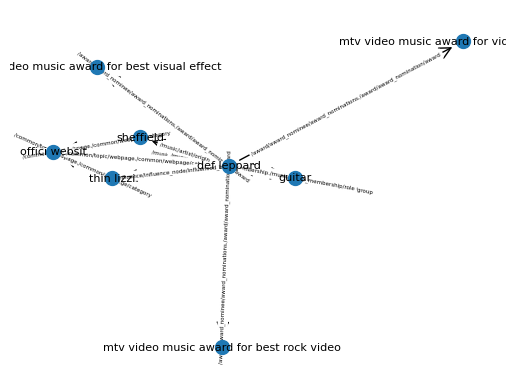

In [ ]:
G = fbkb_graph.get_subgraph(entity_mid)
# Position the nodes using a layout
pos = nx.spring_layout(G, seed=95)

# Draw the nodes with labels
node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

# Draw the edges with labels
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=4)

# Remove axis
plt.axis('off')
# Display the graph
plt.show()
